In [1]:
%cd ../../..

/home/majed_alshaibani/Experiments/DotlessArabic


In [2]:
import json
from functools import lru_cache
from collections import Counter

import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.stats import linregress

from dotless_arabic.tokenizers import DisjointLetterTokenizer,FarasaMorphologicalTokenizer, WordTokenizer

In [3]:
@lru_cache()
def words_counter(dataset_name, tokenizer_name, is_dotted=True):
  # loading the tokens frequency json file
    if is_dotted is True:
        counts_file_name = f'dotted_{tokenizer_name}.json'
    else:
        counts_file_name = f'undotted_{tokenizer_name}.json'
    counts_file_path = f'dotless_arabic/datasets/{dataset_name}/tokens_count/{counts_file_name}'
    counter = Counter(json.load(open(counts_file_path)))
    return counter

In [4]:
def get_zipf_constants(counter):
    heighest_frequency = counter.most_common(1)[-1][1]
    X = np.log(heighest_frequency) * np.log((np.arange(len(counter)) + 1))
    Y = np.log(np.array(list(counter.values())))
    slope, intercept, *_ = linregress(X, Y)
    return np.exp(slope), np.exp(intercept)

In [5]:
counter = words_counter(dataset_name='sanadset_hadeeth',tokenizer_name=WordTokenizer.__name__)
get_zipf_constants(counter)

(0.8928660513374223, 541260119.2298453)

In [6]:
all_datasets_names = [
    'quran',
    'sanadset hadeeth',
    'poems',
    'wikipedia',
    'news',
    'aggregated',
]

In [7]:
def plot_zipf_multiple(figsize=(18, 18), top_words=10_000_000,fontsize=10):
    # https://github.com/MagedSaeed/zipfs_law
    FONT_SIZE = fontsize
    def _plot(counter, name, axis, log,linestyle=None):
        frequencies = [
            item[1]
            for item in sorted(counter.items(), key=lambda item: item[1], reverse=True)
        ][:top_words]
        ranks = [
            item + 1
            for item in range(
                len(sorted(counter.items(), key=lambda item: item[1], reverse=True))
            )
        ][:top_words]
        if linestyle is not None:
            axis.plot(ranks, frequencies, label=name,linestyle=linestyle)
        else:
            axis.plot(ranks, frequencies, label=name)

        if log:
            axis.set_xscale("log")
            axis.set_yscale("log")
            # axis.set_ylim(bottom=10**0)
            # axis.set_ylim(top=10**7.5)

        # add axis labels, title, and legend
        # plt.xlabel('Rank', fontsize=15)
        # plt.ylabel('Frequency', fontsize=15)
        title = "Frequency vs Rank for Words in a Text"
        if log:
            title = "Logorithmic " + title
        # axis.set_title(title)
        axis.legend(loc="upper right",fontsize = f'{FONT_SIZE}')
        
    tokenizers_names = (
        WordTokenizer.__name__,
        FarasaMorphologicalTokenizer.__name__,
        DisjointLetterTokenizer.__name__,
    )

    figure, axis = plt.subplots(nrows=len(tokenizers_names), ncols=2, figsize=figsize,dpi=200,layout='constrained')
    
    plt.rc('font',size=FONT_SIZE)
    figure.supxlabel('Rank',fontsize=FONT_SIZE)
    figure.supylabel('Frequencies',fontsize=FONT_SIZE)

    for irow,tokenizer_name in enumerate(tokenizers_names):
        first_col_datasets_names = [
            'quran',
            'sanadset_hadeeth',
            'wikipedia',
        ]
        second_col_datasets_names = [
            'poems',
            'news',
            'aggregated',
        ]
        for dataset_name in first_col_datasets_names:
            dotted_counter = words_counter(dataset_name=dataset_name,tokenizer_name=tokenizer_name)
            undotted_counter = words_counter(dataset_name=dataset_name,tokenizer_name=tokenizer_name,is_dotted=False)
            alpha_dotted, c_dotted = get_zipf_constants(counter=dotted_counter)
            highest_frequency_dotted = dotted_counter.most_common(2)[-1][1]
            alpha_undotted, c_undotted = get_zipf_constants(counter=undotted_counter)
            print('-'*100)
            print('alpha dotted for',dataset_name,' and tokenizer ', tokenizer_name ,' is:',alpha_dotted)
            print('alpha undotted for',dataset_name,' and tokenizer ', tokenizer_name ,' is:',alpha_undotted)
            print('-'*100)
            
            # logarithmic fit
            _plot(
                counter=dotted_counter,
                name=dataset_name+f" dataset (α={alpha_dotted:.4f})",
                axis=axis[irow,0],
                log=True,
            )
            _plot(
                counter=undotted_counter,
                name="undotted " + dataset_name + f" dataset (α={alpha_undotted:.4f})",
                axis=axis[irow,0],
                log=True,
            )
            
            _plot(
                counter={
                    # rank:heighest_frequency*(1/rank) # use the estimated zipf's values
                    # rank:  freqs_sum / c * rank **(-alpha) # use the estimated zipf's values
                    rank: highest_frequency_dotted / (rank**alpha_dotted)
                    for rank, frequency in enumerate(
                        sorted(
                            dotted_counter.values(),
                            reverse=True,
                        ),
                        start=1,
                    )
                },
                name=f"zipfian regression fit for dotted {dataset_name} dataset",
                axis=axis[irow,0],
                log=True,
                linestyle='dashed',
            )
        for dataset_name in second_col_datasets_names:
            dotted_counter = words_counter(dataset_name=dataset_name,tokenizer_name=tokenizer_name)
            undotted_counter = words_counter(dataset_name=dataset_name,tokenizer_name=tokenizer_name,is_dotted=False)
            alpha_dotted, c_dotted = get_zipf_constants(counter=dotted_counter)
            highest_frequency_dotted = dotted_counter.most_common(2)[-1][1]
            alpha_undotted, c_undotted = get_zipf_constants(counter=undotted_counter)
            print('-'*100)
            print('alpha dotted for',dataset_name,' and tokenizer ', tokenizer_name ,' is:',alpha_dotted)
            print('alpha undotted for',dataset_name,' and tokenizer ', tokenizer_name ,' is:',alpha_undotted)
            print('-'*100)
            
            # logarithmic fit
            _plot(
                counter=dotted_counter,
                name=dataset_name+f" dataset (α={alpha_dotted:.4f})",
                axis=axis[irow,1],
                log=True,
            )
            _plot(
                counter=undotted_counter,
                name="undotted " + dataset_name + f" dataset (α={alpha_undotted:.4f})",
                axis=axis[irow,1],
                log=True,
            )
            _plot(
                counter={
                    # rank:heighest_frequency*(1/rank) # use the estimated zipf's values
                    # rank:  freqs_sum / c * rank **(-alpha) # use the estimated zipf's values
                    rank: highest_frequency_dotted / (rank**alpha_dotted)
                    for rank, frequency in enumerate(
                        sorted(
                            dotted_counter.values(),
                            reverse=True,
                        ),
                        start=1,
                    )
                },
                name=f"zipfian regression fit for dotted {dataset_name} dataset",
                axis=axis[irow,1],
                log=True,
                linestyle='dashed',
            )

----------------------------------------------------------------------------------------------------
alpha dotted for quran  and tokenizer  WordTokenizer  is: 0.8892741245059449
alpha undotted for quran  and tokenizer  WordTokenizer  is: 0.8837471671842351
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
alpha dotted for sanadset_hadeeth  and tokenizer  WordTokenizer  is: 0.8928660513374223
alpha undotted for sanadset_hadeeth  and tokenizer  WordTokenizer  is: 0.8861611071711374
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
alpha dotted for wikipedia  and tokenizer  WordTokenizer  is: 0.9069105831524584
alpha undotted for wikipedia  and tokenizer  WordTokenizer  is: 0.90108587812033

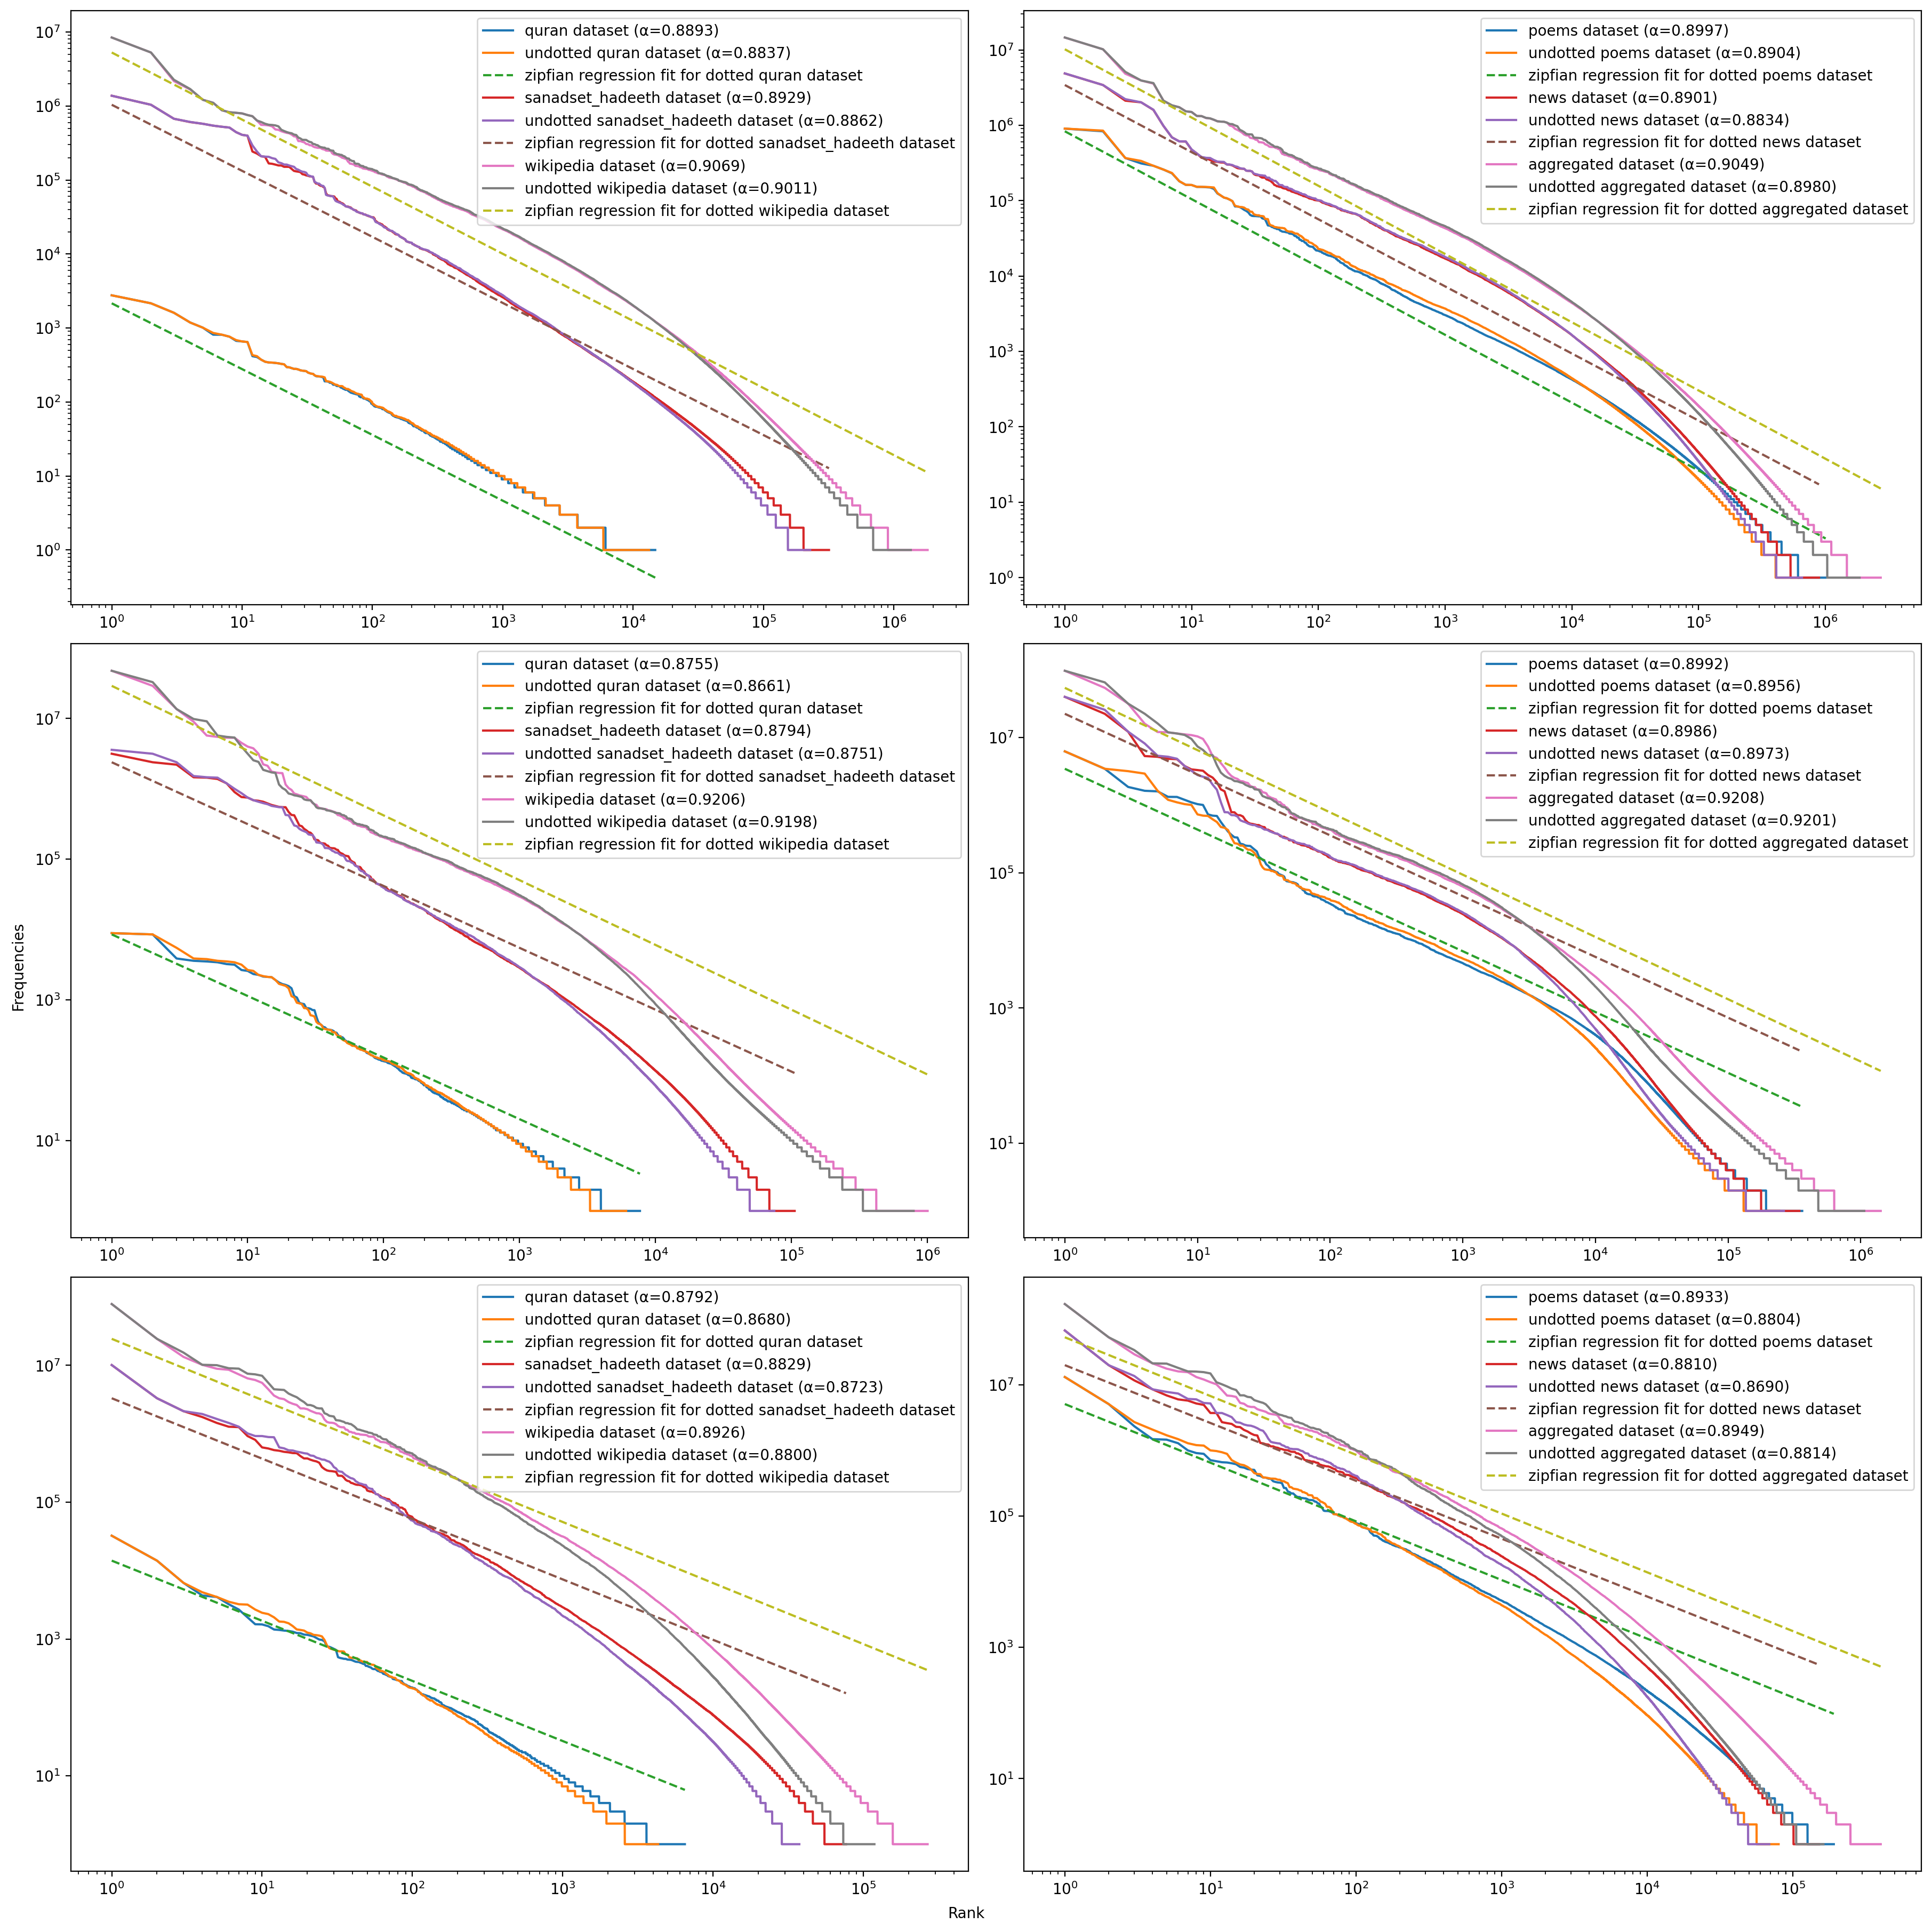

In [8]:
plot_zipf_multiple()